# Notebook used to implement K-Nearest-Neighbor Classification approach


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_curve,auc, roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import pandas.util.testing as tm

/var/folders/zs/_8yyfrhj4_dfc6kw12qzfzv80000gn/T/ipykernel_91008/3506866394.py:17: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read in data and check it read in correctly


In [2]:
processed_df = pd.read_excel('data.xlsx', index_col=0)

In [3]:
processed_df.head()

,imageID,article_url,headline,body,google_visual_api_web_entities_detection_on_lead_image,automatically_generated_caption_of_lead_image,lead_3_sentences_summary_of_full_article_text,presum_summary_of_full_article_text,Q1 Relevant,Q2 Focus,Q3 Theme1,Q3 Theme2,V1image,V2ethnicity,V3relevance,V4relevance,Q4 Image1,Q4 Image2
index,,,,,,,,,,,,,,,,,,
0,10057,http://beta.latimes.com/nation/la-na-paddock-c...,Cremated remains of Las Vegas mass shooter to ...,"""Cremated remains of Las Vegas mass shooter to...",Stephen Paddock 2017 Las Vegas Strip shooting ...,"Eric Paddock, center, with his brother Eric Pa...","""Cremated remains of Las Vegas mass shooter to...","""cremated remains of las vegas mass shooter to...",1,2,7,99,1,0,0,99.0,6,99
1,10073,https://www.yahoo.com/news/florida-shooter-tro...,Florida shooter a troubled loner with white su...,Parkland (Etats-Unis) (AFP) - Nikolas Cruz was...,Nikolas Cruz Stoneman Douglas High School shoo...,"A photograph of the suspect, Nikolas Cruz.",Parkland (Etats-Unis) (AFP) - Nikolas Cruz was...,nikolas cruz was expelled from school after be...,1,1,4,6,1,0,1,0.0,7,0
2,10107,http://www.chicagotribune.com/suburbs/lake-cou...,Vernon Hills teen accused of wearing white sup...,Zak had been the subject of a CLC campus threa...,Vernon Hills FOID Firearm Ammunition White su...,"Zak, who is charged with carrying a gun, is ch...",Zak had been the subject of a CLC campus threa...,zak had been the subject of a clc campus threa...,1,1,6,99,1,0,0,99.0,0,99
3,10112,http://www.chicagotribune.com/suburbs/post-tri...,Griffith student charged with accidentally bri...,"""The members of our staff have been trained on...",Arrest Student Expulsion School Felony Ada Cou...,A student was charged with carrying a gun in a...,"""The members of our staff have been trained on...","""the members of our staff have been trained on...",1,1,5,99,1,0,0,99.0,0,99
4,10156,http://www.cnn.com/2018/02/16/us/exclusive-sch...,Exclusive: Group chat messages show school sho...,"(CNN) In a private Instagram group chat, confe...",Nikolas Cruz Stoneman Douglas High School shoo...,A photo from a Facebook page of the school sho...,"(CNN) In a private Instagram group chat, confe...",the fbi is investigating a private chat group ...,1,1,4,6,1,0,1,0.0,8,0


<AxesSubplot:>

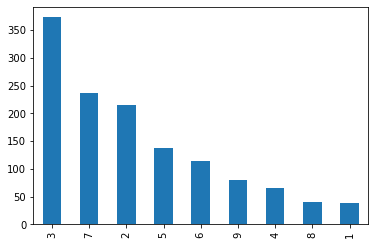

In [4]:
processed_df['Q3 Theme1'].value_counts().plot(kind='bar')

In [5]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   imageID                                                 1300 non-null   object 
 1   article_url                                             1300 non-null   object 
 2   headline                                                1300 non-null   object 
 3   body                                                    1300 non-null   object 
 4   google_visual_api_web_entities_detection_on_lead_image  1298 non-null   object 
 5   automatically_generated_caption_of_lead_image           1300 non-null   object 
 6   lead_3_sentences_summary_of_full_article_text           1299 non-null   object 
 7   presum_summary_of_full_article_text                     1299 non-null   object 
 8   Q1 Relevant                           

### Convert reviews to sparse matrix using TF.IDF

In [6]:
num_samples = 1300

## Lead 3 Sentences Summary

In [7]:
vectorizer = TfidfVectorizer(max_features=1000)
words2vec = vectorizer.fit_transform(processed_df['lead_3_sentences_summary_of_full_article_text'].sample(n=num_samples, random_state=1).values.astype('U'))

#### Split Data into Train, Cross-Validation, and Test

In [8]:
X=processed_df['lead_3_sentences_summary_of_full_article_text'].values.astype('U')
Y=processed_df['Q3 Theme1'].values
Y = preprocessing.label_binarize(Y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 99])

In [9]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [10]:
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2)

In [11]:
X_train_tokens=vectorizer.transform(X_train)
X_test_tokens=vectorizer.transform(X_test)
X_cv_tokens=vectorizer.transform(X_cv)

#### Function to build KNN model

In [12]:
def build_knn_model(num_neighbors, x_train, x_test, y_train):
    knn=KNeighborsClassifier(n_neighbors=num_neighbors,algorithm='brute')
    knn.fit(x_train,y_train)
    predict=knn.predict(x_test)
    return knn

#### Perform Kfold cross-validation and Grid Search to tune k and visualize result

Fitting 5 folds for each of 12 candidates, totalling 60 fits


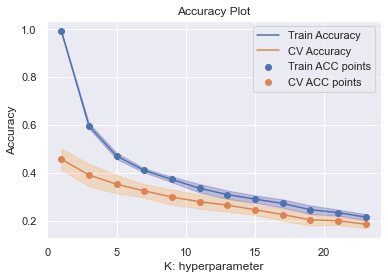

4 Fold CV Accuracy:  0.45673076923076916


In [13]:
cross_validation=KFold(n_splits=5)
myList = list(range(0,25))
K=list(filter(lambda x: x % 2 != 0, myList))
neighbors=KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))}
clf = GridSearchCV(neighbors, parameters, cv=cross_validation,scoring='accuracy',return_train_score=True, n_jobs=-1, verbose=1)
clf.fit(X_train_tokens, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_acc= clf.cv_results_['mean_train_score']
train_acc_std= clf.cv_results_['std_train_score']
cv_acc = clf.cv_results_['mean_test_score'] 
cv_acc_std= clf.cv_results_['std_test_score']
best_k = clf.best_params_['n_neighbors']

sns.set()
plt.plot(K, train_acc, label='Train Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_acc - train_acc_std,train_acc + train_acc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_acc, label='CV Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_acc - cv_acc_std,cv_acc + cv_acc_std,alpha=0.2,color='darkorange')
plt.scatter(K, train_acc, label='Train ACC points')
plt.scatter(K, cv_acc, label='CV ACC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.show()
print("4 Fold CV Accuracy: ", cv_acc[0])


#### Build KNN model with selected k=1 

In [14]:
k = 1
knn = build_knn_model(k, X_train_tokens, X_test_tokens, Y_train)
joblib.dump(knn,  'lead3_knn_n1.pkl')

['lead3_knn_n1.pkl']

In [15]:
knn = joblib.load('lead3_knn_n1.pkl')

#### Generate classification report and Confusion matrix to analyze classification model

                               precision    recall  f1-score   support

     Gun/2nd Amendment rights       0.71      1.00      0.83         5
       Gun control/regulation       0.95      0.91      0.93        44
                     Politics       0.97      0.88      0.93        78
                Mental Health       0.64      0.82      0.72        11
School or public space safety       0.88      0.97      0.92        30
               Race/ethnicity       1.00      0.95      0.97        20
               Public opinion       0.98      0.89      0.93        47
              Society/culture       0.85      1.00      0.92        11
        Economic consequences       0.78      1.00      0.88        14

                     accuracy                           0.92       260
                    macro avg       0.86      0.94      0.89       260
                 weighted avg       0.93      0.92      0.92       260



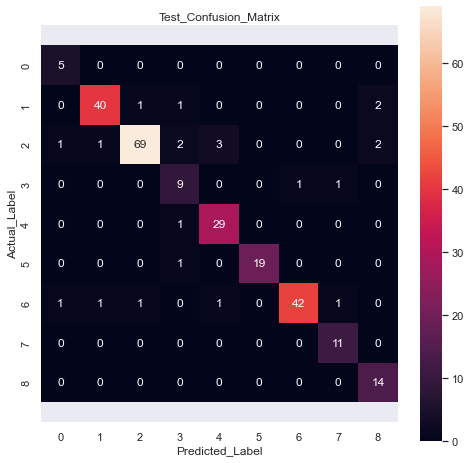

In [16]:
predict = np.array(knn.predict(X_test_tokens), dtype=object)
class_label = [0, 1, 2, 3, 4, 5, 6, 7, 8]
conf_mat = confusion_matrix(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0),labels=class_label)

df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
target_names = ['Gun/2nd Amendment rights', 'Gun control/regulation', 'Politics', 'Mental Health', 'School or public space safety', 'Race/ethnicity', 'Public opinion', 'Society/culture', 'Economic consequences']
report=classification_report(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0), labels=class_label, target_names=target_names)
print(report)
sns.set()
fig = plt.subplots(figsize=(8, 8)) # set size
ax=sns.heatmap(df, annot = True,fmt="d", square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Test_Confusion_Matrix")
plt.xlabel("Predicted_Label")
plt.ylabel("Actual_Label")
plt.show()

## Headline Summary

In [17]:
vectorizer = TfidfVectorizer(max_features=1000)
words2vec = vectorizer.fit_transform(processed_df['headline'].sample(n=num_samples).values.astype('U'))

#### Split Data into Train, Cross-Validation, and Test

In [18]:
X=processed_df['headline'].values.astype('U')
Y=processed_df['Q3 Theme1'].values
Y = preprocessing.label_binarize(Y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 99])

In [19]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [20]:
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2)

In [21]:
X_train_tokens=vectorizer.transform(X_train)
X_test_tokens=vectorizer.transform(X_test)
X_cv_tokens=vectorizer.transform(X_cv)

#### Function to build KNN model

In [22]:
def build_knn_model(num_neighbors, x_train, x_test, y_train):
    knn=KNeighborsClassifier(n_neighbors=num_neighbors,algorithm='brute')
    knn.fit(x_train,y_train)
    predict=knn.predict(x_test)
    return knn

#### Perform Kfold cross-validation and Grid Search to tune k and visualize result

Fitting 5 folds for each of 12 candidates, totalling 60 fits


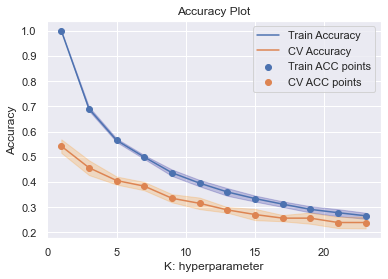

4 Fold CV Accuracy:  0.5423076923076923


In [23]:
cross_validation=KFold(n_splits=5)
myList = list(range(0,25))
K=list(filter(lambda x: x % 2 != 0, myList))
neighbors=KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))}
clf = GridSearchCV(neighbors, parameters, cv=cross_validation,scoring='accuracy',return_train_score=True, n_jobs=-1, verbose=1)
clf.fit(X_train_tokens, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_acc= clf.cv_results_['mean_train_score']
train_acc_std= clf.cv_results_['std_train_score']
cv_acc = clf.cv_results_['mean_test_score'] 
cv_acc_std= clf.cv_results_['std_test_score']
best_k = clf.best_params_['n_neighbors']

sns.set()
plt.plot(K, train_acc, label='Train Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_acc - train_acc_std,train_acc + train_acc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_acc, label='CV Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_acc - cv_acc_std,cv_acc + cv_acc_std,alpha=0.2,color='darkorange')
plt.scatter(K, train_acc, label='Train ACC points')
plt.scatter(K, cv_acc, label='CV ACC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.show()
print("4 Fold CV Accuracy: ", cv_acc[0])


#### Build KNN model with selected k=1 

In [24]:
k = 1
knn = build_knn_model(k, X_train_tokens, X_test_tokens, Y_train)
joblib.dump(knn,  'headline_knn_n1.pkl')

['headline_knn_n1.pkl']

In [25]:
knn = joblib.load('headline_knn_n1.pkl')

#### Generate classification report and Confusion matrix to analyze classification model

                               precision    recall  f1-score   support

     Gun/2nd Amendment rights       0.82      0.82      0.82        11
       Gun control/regulation       0.93      0.93      0.93        44
                     Politics       0.97      0.97      0.97        91
                Mental Health       0.78      0.78      0.78         9
School or public space safety       0.86      0.80      0.83        15
               Race/ethnicity       1.00      0.89      0.94        18
               Public opinion       0.92      0.92      0.92        53
              Society/culture       0.75      1.00      0.86         6
        Economic consequences       0.86      0.92      0.89        13

                     accuracy                           0.92       260
                    macro avg       0.88      0.89      0.88       260
                 weighted avg       0.93      0.92      0.92       260



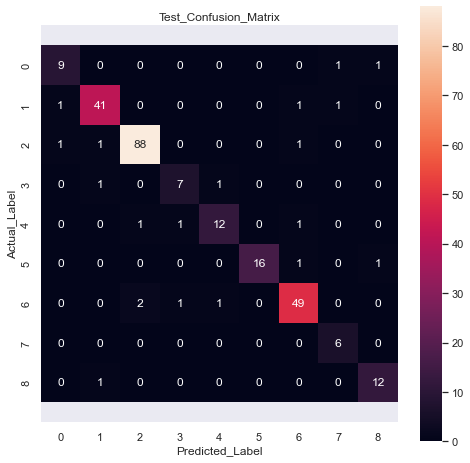

In [26]:
predict = np.array(knn.predict(X_test_tokens), dtype=object)
class_label = [0, 1, 2, 3, 4, 5, 6, 7, 8]
conf_mat = confusion_matrix(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0),labels=class_label)

df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
target_names = ['Gun/2nd Amendment rights', 'Gun control/regulation', 'Politics', 'Mental Health', 'School or public space safety', 'Race/ethnicity', 'Public opinion', 'Society/culture', 'Economic consequences']
report=classification_report(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0), labels=class_label, target_names=target_names)
print(report)
sns.set()
fig = plt.subplots(figsize=(8, 8)) # set size
ax=sns.heatmap(df, annot = True,fmt="d", square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Test_Confusion_Matrix")
plt.xlabel("Predicted_Label")
plt.ylabel("Actual_Label")
plt.show()

## google_visual_api_web_entities_detection_on_lead_image Summary

In [27]:
vectorizer = TfidfVectorizer(max_features=1000)
words2vec = vectorizer.fit_transform(processed_df['google_visual_api_web_entities_detection_on_lead_image'].sample(n=num_samples).values.astype('U'))

#### Split Data into Train, Cross-Validation, and Test

In [28]:
X=processed_df['google_visual_api_web_entities_detection_on_lead_image'].values.astype('U')
Y=processed_df['Q3 Theme1'].values
Y = preprocessing.label_binarize(Y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 99])

In [29]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [30]:
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2)

In [31]:
X_train_tokens=vectorizer.transform(X_train)
X_test_tokens=vectorizer.transform(X_test)
X_cv_tokens=vectorizer.transform(X_cv)

#### Function to build KNN model

In [32]:
def build_knn_model(num_neighbors, x_train, x_test, y_train):
    knn=KNeighborsClassifier(n_neighbors=num_neighbors,algorithm='brute')
    knn.fit(x_train,y_train)
    predict=knn.predict(x_test)
    return knn

#### Perform Kfold cross-validation and Grid Search to tune k and visualize result

Fitting 5 folds for each of 12 candidates, totalling 60 fits


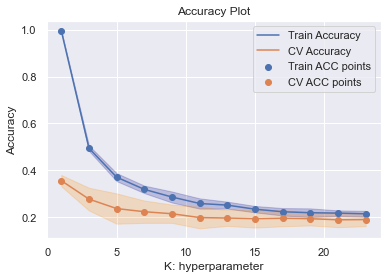

4 Fold CV Accuracy:  0.3557692307692308


In [33]:
cross_validation=KFold(n_splits=5)
myList = list(range(0,25))
K=list(filter(lambda x: x % 2 != 0, myList))
neighbors=KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))}
clf = GridSearchCV(neighbors, parameters, cv=cross_validation,scoring='accuracy',return_train_score=True, n_jobs=-1, verbose=1)
clf.fit(X_train_tokens, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_acc= clf.cv_results_['mean_train_score']
train_acc_std= clf.cv_results_['std_train_score']
cv_acc = clf.cv_results_['mean_test_score'] 
cv_acc_std= clf.cv_results_['std_test_score']
best_k = clf.best_params_['n_neighbors']

sns.set()
plt.plot(K, train_acc, label='Train Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_acc - train_acc_std,train_acc + train_acc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_acc, label='CV Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_acc - cv_acc_std,cv_acc + cv_acc_std,alpha=0.2,color='darkorange')
plt.scatter(K, train_acc, label='Train ACC points')
plt.scatter(K, cv_acc, label='CV ACC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.show()
print("4 Fold CV Accuracy: ", cv_acc[0])


#### Build KNN model with selected k=1 

In [34]:
k = 1
knn = build_knn_model(k, X_train_tokens, X_test_tokens, Y_train)
joblib.dump(knn,  'google_visual_api_web_entities_detection_on_lead_image_knn_n1.pkl')

['google_visual_api_web_entities_detection_on_lead_image_knn_n1.pkl']

In [35]:
knn = joblib.load('google_visual_api_web_entities_detection_on_lead_image_knn_n1.pkl')

#### Generate classification report and Confusion matrix to analyze classification model

                               precision    recall  f1-score   support

     Gun/2nd Amendment rights       0.57      0.80      0.67         5
       Gun control/regulation       0.82      0.88      0.85        41
                     Politics       0.94      0.84      0.89        81
                Mental Health       0.92      0.79      0.85        14
School or public space safety       0.93      0.89      0.91        28
               Race/ethnicity       0.96      0.93      0.94        27
               Public opinion       0.75      0.90      0.82        42
              Society/culture       0.86      0.75      0.80         8
        Economic consequences       0.86      0.86      0.86        14

                     accuracy                           0.87       260
                    macro avg       0.84      0.85      0.84       260
                 weighted avg       0.88      0.87      0.87       260



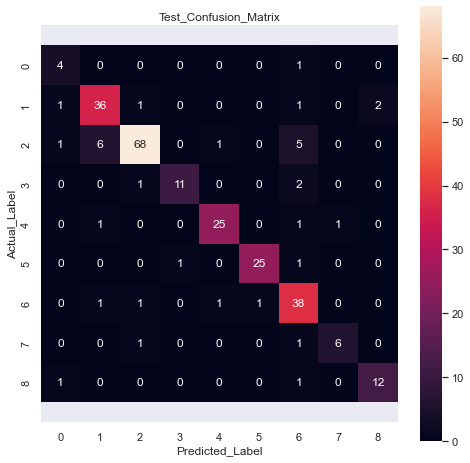

In [36]:
predict = np.array(knn.predict(X_test_tokens), dtype=object)
class_label = [0, 1, 2, 3, 4, 5, 6, 7, 8]
conf_mat = confusion_matrix(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0),labels=class_label)

df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
target_names = ['Gun/2nd Amendment rights', 'Gun control/regulation', 'Politics', 'Mental Health', 'School or public space safety', 'Race/ethnicity', 'Public opinion', 'Society/culture', 'Economic consequences']
report=classification_report(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0), labels=class_label, target_names=target_names)
print(report)
sns.set()
fig = plt.subplots(figsize=(8, 8)) # set size
ax=sns.heatmap(df, annot = True,fmt="d", square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Test_Confusion_Matrix")
plt.xlabel("Predicted_Label")
plt.ylabel("Actual_Label")
plt.show()

## Body Summary

In [37]:
vectorizer = TfidfVectorizer(max_features=1000)
words2vec = vectorizer.fit_transform(processed_df['body'].sample(n=num_samples).values.astype('U'))

#### Split Data into Train, Cross-Validation, and Test

In [38]:
X=processed_df['body'].values.astype('U')
Y=processed_df['Q3 Theme1'].values
Y = preprocessing.label_binarize(Y, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 99])

In [39]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [40]:
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2)

In [41]:
X_train_tokens=vectorizer.transform(X_train)
X_test_tokens=vectorizer.transform(X_test)
X_cv_tokens=vectorizer.transform(X_cv)

#### Function to build KNN model

In [42]:
def build_knn_model(num_neighbors, x_train, x_test, y_train):
    knn=KNeighborsClassifier(n_neighbors=num_neighbors,algorithm='brute')
    knn.fit(x_train,y_train)
    predict=knn.predict(x_test)
    return knn

#### Perform Kfold cross-validation and Grid Search to tune k and visualize result

Fitting 5 folds for each of 12 candidates, totalling 60 fits


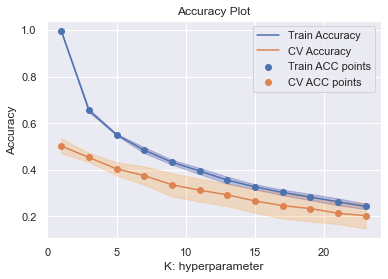

4 Fold CV Accuracy:  0.5019230769230769


In [43]:
cross_validation=KFold(n_splits=5)
myList = list(range(0,25))
K=list(filter(lambda x: x % 2 != 0, myList))
neighbors=KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))}
clf = GridSearchCV(neighbors, parameters, cv=cross_validation,scoring='accuracy',return_train_score=True, n_jobs=-1, verbose=1)
clf.fit(X_train_tokens, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_acc= clf.cv_results_['mean_train_score']
train_acc_std= clf.cv_results_['std_train_score']
cv_acc = clf.cv_results_['mean_test_score'] 
cv_acc_std= clf.cv_results_['std_test_score']
best_k = clf.best_params_['n_neighbors']

sns.set()
plt.plot(K, train_acc, label='Train Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_acc - train_acc_std,train_acc + train_acc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_acc, label='CV Accuracy')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_acc - cv_acc_std,cv_acc + cv_acc_std,alpha=0.2,color='darkorange')
plt.scatter(K, train_acc, label='Train ACC points')
plt.scatter(K, cv_acc, label='CV ACC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.show()
print("4 Fold CV Accuracy: ", cv_acc[0])


#### Build KNN model with selected k=1 

In [44]:
k = 1
knn = build_knn_model(k, X_train_tokens, X_test_tokens, Y_train)
joblib.dump(knn,  'body_knn_n1.pkl')

['body_knn_n1.pkl']

In [45]:
knn = joblib.load('body_knn_n1.pkl')

#### Generate classification report and Confusion matrix to analyze classification model

                               precision    recall  f1-score   support

     Gun/2nd Amendment rights       0.86      0.60      0.71        10
       Gun control/regulation       0.89      0.87      0.88        45
                     Politics       0.95      0.90      0.93        62
                Mental Health       0.83      0.62      0.71         8
School or public space safety       0.83      0.91      0.87        33
               Race/ethnicity       0.97      0.93      0.95        30
               Public opinion       0.88      0.94      0.91        49
              Society/culture       0.67      0.67      0.67         6
        Economic consequences       0.81      1.00      0.89        17

                     accuracy                           0.89       260
                    macro avg       0.85      0.83      0.83       260
                 weighted avg       0.89      0.89      0.89       260



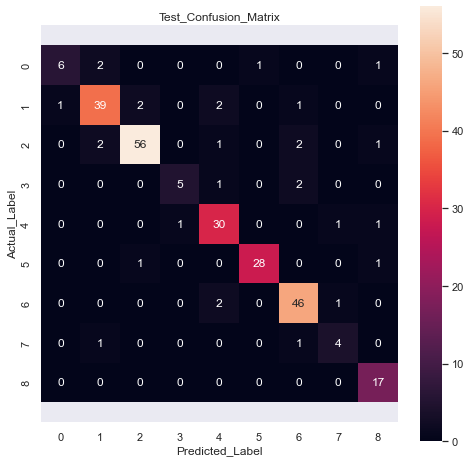

In [46]:
predict = np.array(knn.predict(X_test_tokens), dtype=object)
class_label = [0, 1, 2, 3, 4, 5, 6, 7, 8]
conf_mat = confusion_matrix(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0),labels=class_label)

df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
target_names = ['Gun/2nd Amendment rights', 'Gun control/regulation', 'Politics', 'Mental Health', 'School or public space safety', 'Race/ethnicity', 'Public opinion', 'Society/culture', 'Economic consequences']
report=classification_report(np.array(Y_test).argmax(axis=1), predict.T.argmax(axis=0), labels=class_label, target_names=target_names)
print(report)
sns.set()
fig = plt.subplots(figsize=(8, 8)) # set size
ax=sns.heatmap(df, annot = True,fmt="d", square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Test_Confusion_Matrix")
plt.xlabel("Predicted_Label")
plt.ylabel("Actual_Label")
plt.show()